In [1]:
import scipy.io as sio
from scipy.fft import fft
import os,glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mat4py import loadmat

In [2]:
import scipy.io as sio
from mat4py import loadmat
import numpy as np

def wfft_hz(filename, Hz_Lthr, Hz_Hthr):
    '"Lthr: lower threshold; Hthr: high threshold"'
    data = loadmat(filename)
    fft_data = fft(data['data'])
    NFFT = math.floor(len(data['data'])/2)+1
    fft_data = abs(fft_data[1:NFFT])
    f = data['Fs']/2 * np.linspace(0, 1, NFFT)
    idx = [i for i, e in enumerate(f) if e>= Hz_Lthr and e <= Hz_Hthr ] 
    X=f[idx]
    y=fft_data[idx]
    return X, y

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def remove_trends_from_signal(X, y):
    Y = [ round(item, 6) for elem in y for item in elem ]
    m, b = np.polyfit(X, y, 1)
    Y = Y-(m*X)
    return Y

def find_top_peaks_with_guasian_weight(file, Hz_Lthr, Hz_Hthr, mu, sigma, number_of_peak):
    [X, y] =  wfft_hz(file,Hz_Lthr, Hz_Hthr)
    Y = remove_trends_from_signal(X,y)
    peaks, _ = find_peaks(Y, height=0)
    gaussoan_weight=gaussian(np.array(X), mu, sigma)
    y_with_weight = Y*gaussoan_weight
    top_peaks = heapq.nlargest(number_of_peak, y_with_weight[peaks])
    top_peaks_idx = [index[0] for index in [np.where(y_with_weight == peak)[0] for peak in top_peaks]]
    top_peaks_idx.sort()
    return X, Y, top_peaks_idx

def find_top_peaks_with_uniform_weight(file, Hz_Lthr, Hz_Hthr, ROI_Hz_Lthr, ROI_Hz_Hthr ,low_weight, high_weight, number_of_peak):
    [X, y] =  wfft_hz(file,Hz_Lthr, Hz_Hthr)
    Y = remove_trends_from_signal(X,y)
    peaks, _ = find_peaks(Y, height=0)
    uniform_weight=get_uniform_weight(X, ROI_Hz_Lthr, ROI_Hz_Hthr, low_weight, high_weight)
    y_with_weight = Y*uniform_weight
    top_peaks = heapq.nlargest(number_of_peak, y_with_weight[peaks])
    top_peaks_idx = [index[0] for index in [np.where(y_with_weight == peak)[0] for peak in top_peaks]]
    top_peaks_idx.sort()
    return X, Y, top_peaks_idx

def find_top_peaks_with_uniform_weight_v2(file, Hz_Lthr, Hz_Hthr, ROI_Hz_Lthr, ROI_Hz_Hthr ,low_weight,
                                          high_weight, high_weight2, number_of_peak):
    [X, y] =  wfft_hz(file,Hz_Lthr, Hz_Hthr)
    Y = remove_trends_from_signal(X,y)
    peaks, _ = find_peaks(Y, height=0)
    uniform_weight=get_uniform_weight_v2(X, ROI_Hz_Lthr, ROI_Hz_Hthr, low_weight, high_weight, high_weight2)
    y_with_weight = Y*uniform_weight
    top_peaks = heapq.nlargest(number_of_peak, y_with_weight[peaks])
    top_peaks_idx = [index[0] for index in [np.where(y_with_weight == peak)[0] for peak in top_peaks]]
    top_peaks_idx.sort()
    return X, Y, top_peaks_idx


def get_uniform_weight(X, Hz_Lthr, Hz_Hthr, low, high):
    result_l = list(filter(lambda x: x < Hz_Lthr, X))
    result_l = np.random.uniform(low, high, len(result_l))
    result_l = sorted(result_l)
    
    result_r = list(filter(lambda x: x > Hz_Hthr, X))
    result_r = np.random.uniform(low, high, len(result_r))
    result_r = sorted(result_r, reverse=True)
    
    uniform_weight = np.random.uniform(high, high, len(X))
    uniform_weight = [x for i, x in enumerate(uniform_weight) if X[i] >= Hz_Lthr and X[i] <= Hz_Hthr]
    
    uniform_weight.extend(result_r)
    result_l.extend(uniform_weight)
    return result_l

def get_uniform_weight_v2(X, Hz_Lthr, Hz_Hthr, low, high, high2):
    result_l = list(filter(lambda x: x < Hz_Lthr, X))
    result_l = np.random.uniform(low, high, len(result_l))
    result_l = sorted(result_l)
    
    result_r = list(filter(lambda x: x > Hz_Hthr, X))
    result_r = np.random.uniform(low, high, len(result_r))
    result_r = sorted(result_r, reverse=True)
    
    uniform_weight = np.random.uniform(high, high2, len(X))
    uniform_weight = sorted(uniform_weight, reverse=True)
    uniform_weight = [x for i, x in enumerate(uniform_weight) if X[i] >= Hz_Lthr and X[i] <= Hz_Hthr]
    
    uniform_weight.extend(result_r)
    result_l.extend(uniform_weight)
    return result_l
    

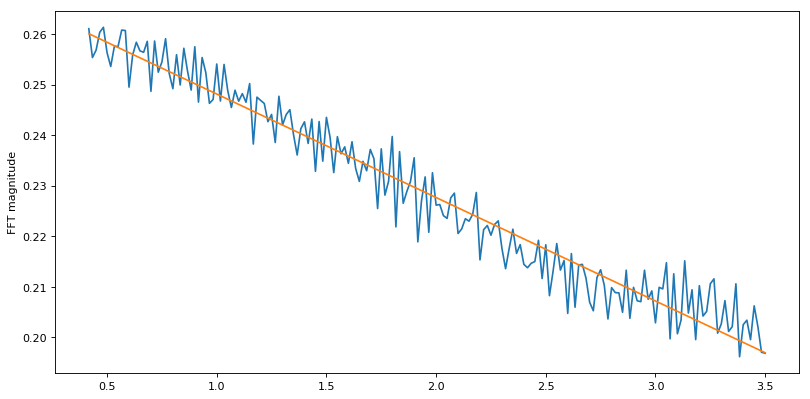

In [3]:
Hz_Lthr, Hz_Hthr =0.4, 3.5 
file = '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_R_A_1.mat'
[X,y] =  wfft_hz(file,Hz_Lthr, Hz_Hthr)

plt.figure(figsize=(12, 6), dpi=80)
plt.plot(X, y)
m, b = np.polyfit(X, y, 1)
plt.plot(X, m*X + b)
plt.ylabel('FFT magnitude')
plt.show()

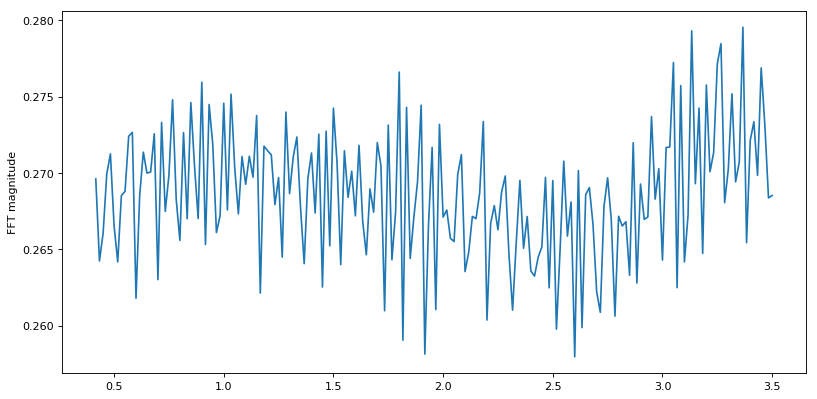

In [4]:
#remove trends from data
file = '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_R_A_1.mat'

[X,y] =  wfft_hz(file,Hz_Lthr, Hz_Hthr)
plt.figure(figsize=(12, 6), dpi=80)
Y = remove_trends_from_signal(X, y)
plt.plot(X, Y)
plt.ylabel('FFT magnitude')
#plt.text(6, 0.3, "Min:"+str(min(y))+"  Max:"+str(max(y))  ,fontsize=16, bbox=dict(facecolor='red', alpha=0.5))
plt.show()

In [5]:
uniform_weight= get_uniform_weight(X, 0.8, 2.5, 0.01, 0.07)

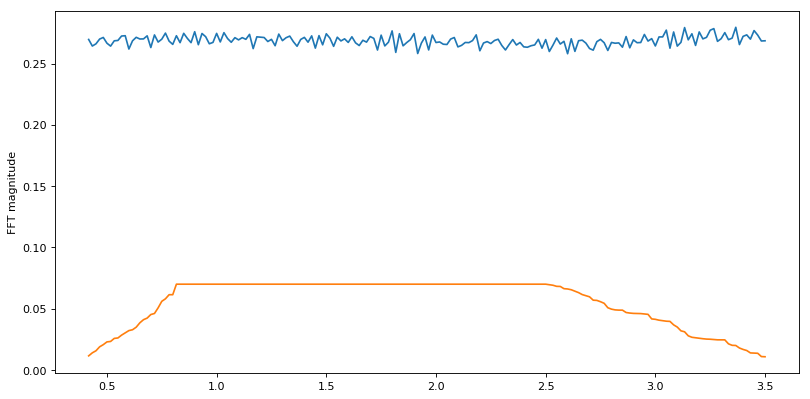

In [6]:
Y = remove_trends_from_signal(X, y)
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(X, Y)
plt.plot(X, uniform_weight)
plt.ylabel('FFT magnitude')
plt.show()

In [7]:
fft_with_weight = Y*uniform_weight

In [8]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(Y, height=0)
len(peaks)

65

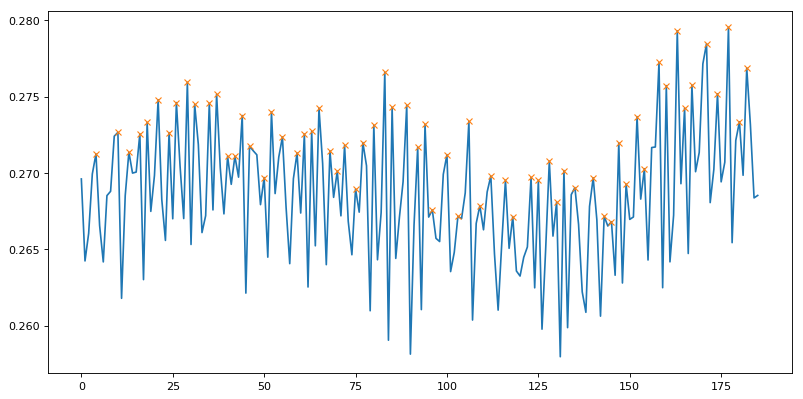

In [9]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(Y)
plt.plot(peaks, Y[peaks], "x")
plt.show()

In [10]:
import heapq
number_of_elements = 5
top_ten_peaks = heapq.nlargest(number_of_elements, fft_with_weight[peaks])

In [11]:
top_ten_peaks_index = [index[0] for index in [np.where(fft_with_weight == peak)[0] for peak in top_ten_peaks]]
top_ten_peaks_index.sort()
top_ten_peaks_index

[26, 29, 35, 37, 83]

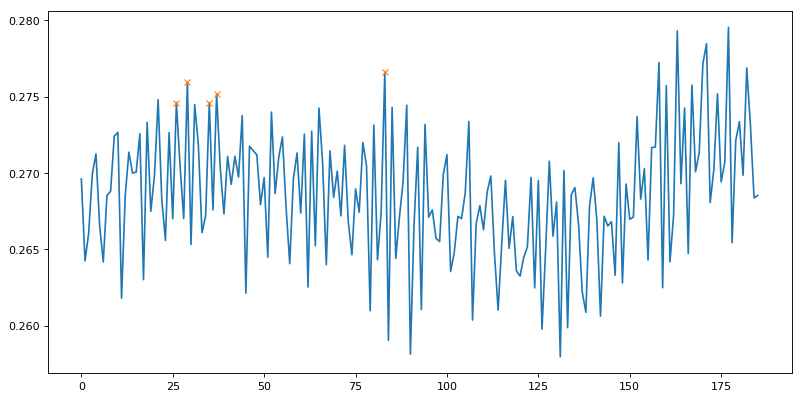

In [12]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(Y)
plt.plot(top_ten_peaks_index, Y[top_ten_peaks_index], "x")
plt.show()

In [13]:

sorted(top_ten_peaks_index)

[26, 29, 35, 37, 83]

In [14]:
[X[peak]*60 for peak in top_ten_peaks_index]

[51.0, 54.0, 60.0, 62.00000000000001, 108.0]

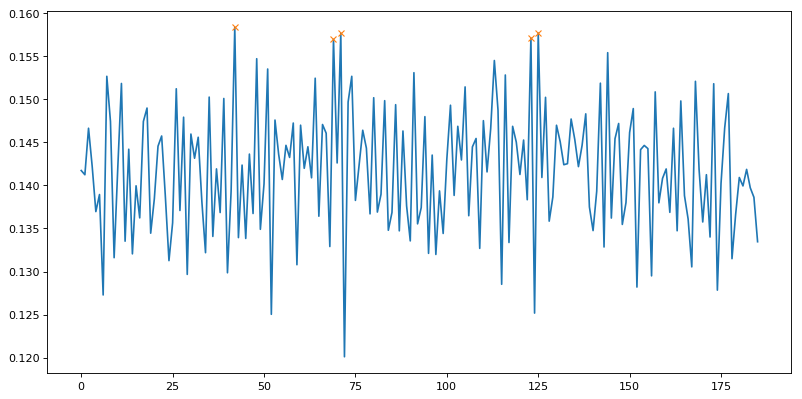

In [15]:
file = '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_L_A_1.mat'
[X,y] =  wfft_hz(file,Hz_Lthr, Hz_Hthr)
# remove the trend
Y = remove_trends_from_signal(X,y)
peaks, _ = find_peaks(Y, height=0)
uniform_weight=get_uniform_weight(X, 0.8, 2.5, 0.01, 0.04)

fft_with_weight = Y*uniform_weight
top_ten_peaks = heapq.nlargest(number_of_elements, fft_with_weight[peaks])

top_ten_peaks_index = [index[0] for index in [np.where(fft_with_weight == peak)[0] for peak in top_ten_peaks]]
top_ten_peaks_index.sort()


plt.figure(figsize=(12, 6), dpi=80)
plt.plot(Y)
plt.plot(top_ten_peaks_index, Y[top_ten_peaks_index], "x")
plt.show()


In [16]:
[X[peak]*60 for peak in top_ten_peaks_index]

[67.0, 94.0, 95.99999999999999, 148.0, 150.0]

In [17]:
X, Y, top_peaks = find_top_peaks_with_uniform_weight('../datasets/Age_A/Age_A_Male/Sub 36/36Neck_L_A_1.mat', 0.4, 3.5, 0.8, 2.5 ,0.01, 0.04, 5)

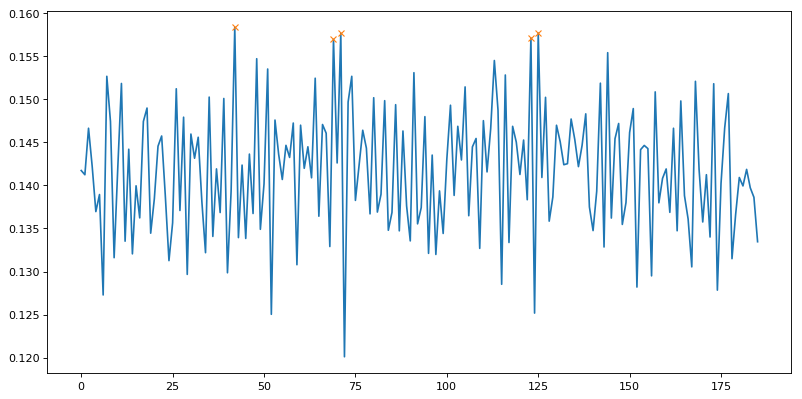

In [18]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(Y)
plt.plot(top_peaks, Y[top_peaks], "x")
plt.show()

In [19]:
[round(X[peak]*60,0) for peak in top_peaks]

[67.0, 94.0, 96.0, 148.0, 150.0]

In [20]:
Hz_Lthr, Hz_Hthr, ROI_Hz_Lthr, ROI_Hz_Hthr ,low_weight, high_weight, no_peaks= 0.4, 3.5, 0.8, 2.5, 0.01, 0.04, 5

files_36 = ['../datasets/Age_A/Age_A_Male/Sub 36/36Neck_L_A_1.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_L_A_2.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_L_A_3.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_R_A_1.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_R_A_2.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_R_A_3.mat']


all_peaks_hr = []

for  file in files_36:
    X, Y, top_peaks = find_top_peaks_with_uniform_weight(file, Hz_Lthr, Hz_Hthr, ROI_Hz_Lthr, ROI_Hz_Hthr ,low_weight, high_weight, no_peaks)
    top_peaks_hr = [round(X[peak]*60) for peak in top_peaks]
    print(top_peaks_hr)
    

[67.0, 94.0, 96.0, 148.0, 150.0]
[61.0, 68.0, 100.0, 124.0, 149.0]
[100.0, 108.0, 112.0, 135.0, 142.0]
[51.0, 54.0, 60.0, 62.0, 108.0]
[74.0, 80.0, 113.0, 132.0, 143.0]
[72.0, 93.0, 99.0, 101.0, 137.0]


In [21]:
Hz_Lthr, Hz_Hthr, ROI_Hz_Lthr, ROI_Hz_Hthr ,low_weight, high_weight, no_peaks= 0.4, 3.5, 0.8, 2.5, 0.01, 0.07, 5

files_36 = ['../datasets/Age_A/Age_A_Male/Sub 36/36Neck_L_A_1.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_L_A_2.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_L_A_3.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_R_A_1.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_R_A_2.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_R_A_3.mat']


all_peaks = []

for  file in files_36:
    X, Y, top_peaks = find_top_peaks_with_uniform_weight(file, Hz_Lthr, Hz_Hthr, ROI_Hz_Lthr, ROI_Hz_Hthr, low_weight, high_weight, no_peaks)
    top_peaks_hr = [round(X[peak]*60) for peak in top_peaks]
    all_peaks.append(top_peaks_hr)
    print(top_peaks_hr)

[67.0, 94.0, 96.0, 148.0, 150.0]
[61.0, 68.0, 100.0, 124.0, 149.0]
[100.0, 108.0, 112.0, 135.0, 142.0]
[51.0, 54.0, 60.0, 62.0, 108.0]
[74.0, 80.0, 113.0, 132.0, 143.0]
[72.0, 93.0, 99.0, 101.0, 137.0]


In [22]:
!pip3 install kmeans1d

You should consider upgrading via the '/Users/ayub/anaconda3/bin/python -m pip install --upgrade pip' command.


In [23]:
flat_list = [item for sublist in all_peaks for item in sublist]
flat_list

[67.0,
 94.0,
 96.0,
 148.0,
 150.0,
 61.0,
 68.0,
 100.0,
 124.0,
 149.0,
 100.0,
 108.0,
 112.0,
 135.0,
 142.0,
 51.0,
 54.0,
 60.0,
 62.0,
 108.0,
 74.0,
 80.0,
 113.0,
 132.0,
 143.0,
 72.0,
 93.0,
 99.0,
 101.0,
 137.0]

In [24]:
import kmeans1d
from collections import Counter

def find_key_with_maxval(d):
    v=list(d.values())
    k=list(d.keys())
    max_v = max(v) 
    return (k[v.index(max_v)], max_v)

def do_clusters_and_find_max_center(item_list, no_of_cluster):
    clusters, centroids = kmeans1d.cluster(flat_list, no_of_cluster)
    counter =  Counter(clusters)
    print(counter)
    print(centroids)
    max_cluster =  find_key_with_maxval(counter)
    return centroids[max_cluster[0]]
    


In [25]:
do_clusters_and_find_max_center(flat_list, 3)

Counter({1: 11, 0: 10, 2: 9})
[64.9, 102.18181818181817, 140.0]


102.18181818181817

In [26]:
uniform_weight= get_uniform_weight_v2(X, 0.8, 2.5, 0.01, 0.06, 0.07)

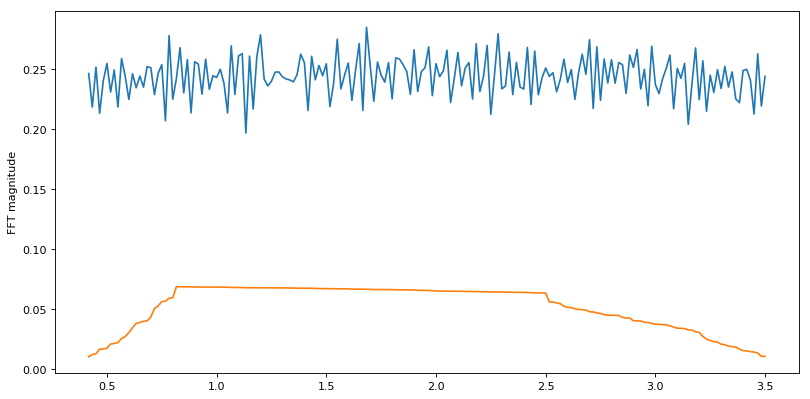

In [27]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(X, Y)
plt.plot(X, uniform_weight)
plt.ylabel('FFT magnitude')
plt.show()

In [50]:
Hz_Lthr, Hz_Hthr, ROI_Hz_Lthr, ROI_Hz_Hthr ,low_weight, high_weight, high_weight2, no_peaks= 0.4, 3.5, 0.8, 2.5, 0.01, 0.07, 0.08, 5

files_36 = ['../datasets/Age_A/Age_A_Male/Sub 36/36Neck_L_A_1.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_L_A_2.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_L_A_3.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_R_A_1.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_R_A_2.mat',
        '../datasets/Age_A/Age_A_Male/Sub 36/36Neck_R_A_3.mat']


all_peaks = []

for  file in files_36:
    X, Y, top_peaks = find_top_peaks_with_uniform_weight_v2(file, Hz_Lthr, Hz_Hthr, ROI_Hz_Lthr, ROI_Hz_Hthr, 
                                                            low_weight, high_weight, high_weight2, no_peaks)
    top_peaks_hr = [round(X[peak]*60) for peak in top_peaks]
    all_peaks.append(top_peaks_hr)
    print(top_peaks_hr)

[51.0, 67.0, 73.0, 94.0, 96.0]
[61.0, 68.0, 71.0, 100.0, 124.0]
[49.0, 52.0, 54.0, 57.0, 60.0]
[49.0, 51.0, 54.0, 56.0, 62.0]
[58.0, 69.0, 74.0, 80.0, 113.0]
[50.0, 64.0, 72.0, 93.0, 101.0]


In [51]:
flat_list = [item for sublist in all_peaks for item in sublist]
do_clusters_and_find_max_center(flat_list, 5)

Counter({0: 8, 2: 8, 1: 7, 3: 5, 4: 2})
[51.25, 59.714285714285715, 71.75, 96.8, 118.5]


51.25

In [52]:
clusters, centroids = kmeans1d.cluster(flat_list, 5)
counter =  Counter(clusters)

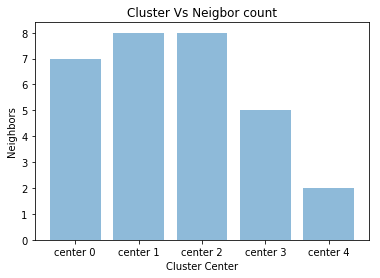

In [39]:
import matplotlib.pyplot as plt
centers = ['center 0', 'center 1', 'center 2', 'center 3', 'center 4']
x_pos = [i for i, _ in enumerate(centers)]
plt.bar(counter.keys(), counter.values(), align='center', alpha=0.5)
plt.xticks(x_pos, centers)
plt.ylabel('Neighbors')
plt.xlabel('Cluster Center')
plt.title('Cluster Vs Neigbor count')
plt.show()

In [40]:
max_cluster = find_key_with_maxval(counter)
max_cluster_center_value = centroids.pop(max_cluster[0])

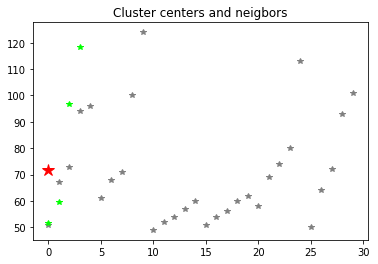

In [41]:
import matplotlib.pyplot as plt
plt.plot(flat_list, '*', color=[0.5, 0.5, 0.5]) # Gray stars
plt.plot(centroids, '*', color=[0.0, 1.0, 0.0]) # Gray stars
plt.plot(max_cluster_center_value, '*', color=[1.0, 0.0, 0.0],markersize=12) # Gray stars
plt.title('Cluster centers and neigbors')
plt.show()

In [42]:
print('The center with max neigbor {}'.format(max_cluster_center_value))

The center with max neigbor 71.75
